# Анализ списка гипотез для увеличения выручки.

Мне предстоит проанализировать данные крупного интернет-магазина. Мы имеем список гипотез для увеличения выручки.

Цель проекта:
- Приоритизировать гипотезы, запустить A/B-тест и проанализируйте результаты. 
В моем распоряжении следующие данные: 
- В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.
- Результаты A/B-тест, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

Таким образом, мое исследование пройдет в 2 основных этапа:
- Часть 1. Приоритизация гипотез.
- Часть 2. Анализ A/B-теста

## Часть 1. Приоритизация гипотез.

### Для начала загрузим данные и подготовим их к анализу

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import scipy.stats as stats
register_matplotlib_converters()

In [2]:
try:
   hypothesis = pd.read_csv('/Users/osipovamichilina/Documents/hypothesis.csv')

except:
   hypothesis = pd.read_csv('/datasets/hypothesis.csv', sep=',')

In [3]:
try:
   orders = pd.read_csv('/Users/osipovamichilina/Documents/orders.csv')

except:
   orders = pd.read_csv('/datasets/orders.csv', sep=',')

In [4]:
try:
   visitors = pd.read_csv('/Users/osipovamichilina/Documents/visitors.csv')

except:
   visitors = pd.read_csv('/datasets/visitors.csv', sep=',')

In [5]:
hypothesis.info()
orders.info()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   

In [6]:
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.lower()
visitors.columns = visitors.columns.str.lower()

In [7]:
orders.head(5)

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
orders.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionid  1197 non-null   int64 
 1   visitorid      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
orders['transactionid'] = orders['transactionid'].astype('object')

In [10]:
orders['visitorid'] = orders['visitorid'].astype('object')

In [11]:
orders.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionid  1197 non-null   object
 1   visitorid      1197 non-null   object
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(1), object(4)
memory usage: 46.9+ KB


In [12]:
orders_new = (
    orders.groupby('group', as_index=False)
    .agg({'transactionid': 'sum',
         'visitorid': 'sum',}))
orders_new.head(5)

,group,transactionid,visitorid
0,A,1191226823565,1211535685633
1,B,1389051974914,1381118605657


In [13]:
# проверим данные на наличие пропусков
hypothesis.isna().sum()

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

In [14]:
orders.isna().sum()

transactionid    0
visitorid        0
date             0
revenue          0
group            0
dtype: int64

In [15]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

In [16]:
# проверим данные на наличие дубликатов

hypothesis.duplicated().sum()

0

In [17]:
orders.duplicated().sum()

0

In [18]:
visitors.duplicated().sum()

0

In [19]:
datesGroups = orders[['date', 'group']].drop_duplicates()

In [20]:
orders['date'].min()

'2019-08-01'

In [21]:
orders['date'].max()

'2019-08-31'

1) Анализируемые данные не имеют пропусков, а также дубликатов. Это очень хорошо) Типы данных приведены в соответствие необходимому типу данных. Для удобства названия столбцов приведены к нижнему регистру.

2) Предобработка данных показала что у нас две группы А и В. По таблице orders мы определили, количество пользователей и заказов по группам. Определили даты начала и конца теста, тест длился с 1 по 31 августа 2019 года.

3) Создали массив уникальных пар значений дат и групп теста методом drop_duplicates()

### Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [22]:
hypothesis.head(9)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [23]:
hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

In [24]:
(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))


,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


### Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [25]:
hypothesis['RICE'] = (hypothesis['reach']* hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


### Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

RICE является модификацией метода ICE, они схожи по компонентам, но результат применения будет разный. При этом, данный фреймворк состоит из четырёх компонентов, и приоритизация гипотез будет разная за счет компонента Reach, указывающий на предмет - скольких пользователей затронет изменение, которое вы хотите внести.Таким образом, появление в числителе показателя охвата пользователей сильно меняет картину, то есть приоритизацию.

## Часть 2. Анализ A/B-теста

### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [26]:
orders.head(5)

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [27]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [28]:
# Объявим переменную ordersAggregated
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group'])
    ].agg({
            'date': 'max',
            'group': 'max',
            'transactionid': 'nunique',
            'visitorid': 'nunique',
            'revenue': 'sum',}),
    axis=1,).sort_values(by=['date', 'group'])

In [29]:
# Объявим переменную visitorsAggregated

visitorsAggregated = datesGroups.apply(
lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [30]:
# Определим переменную cumulativeData, объединив ordersAggregated и visitorsAggregated по колонкам 'date', 'group' методом merge()

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

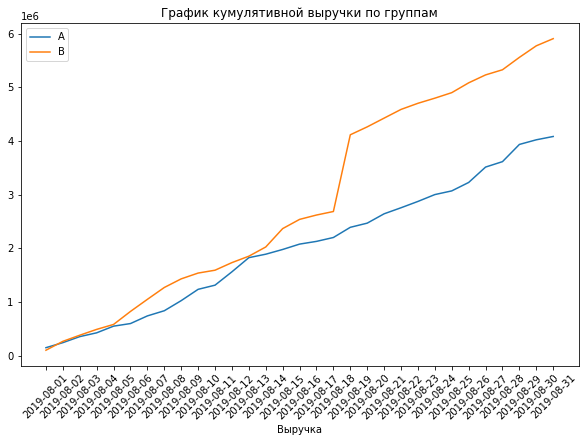

In [31]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

fig = plt.figure(figsize=[10,7])
fig.autofmt_xdate()
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')


plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата заказа')
plt.xlabel('Выручка')

plt.xticks(rotation = 45)


plt.legend() 
plt.show() 

Сегмент В вырваля вперед и продолжал лидировать весь остаток теста. Из этого следует, что аномально большие заказы все-таки влият на результаты.

### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

In [32]:
cumulativeRevenueA.head(5)

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68
6,2019-08-04,425699,84
8,2019-08-05,549917,109


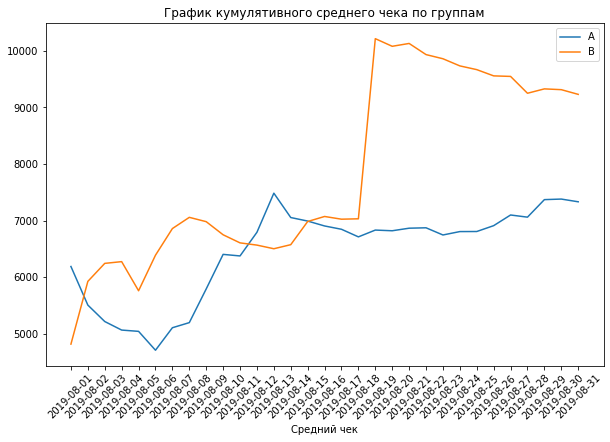

In [33]:
fig = plt.figure(figsize=[10,7])
fig.autofmt_xdate()

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 

plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата заказа')
plt.xlabel('Средний чек')

plt.xticks(rotation = 45)


plt.legend() 
plt.show() 

Кумулятивное значение среднего чека колебается, принимать решение по метрике пока мы не можем. Требуется анализ выбросов.

### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

No handles with labels found to put in legend.


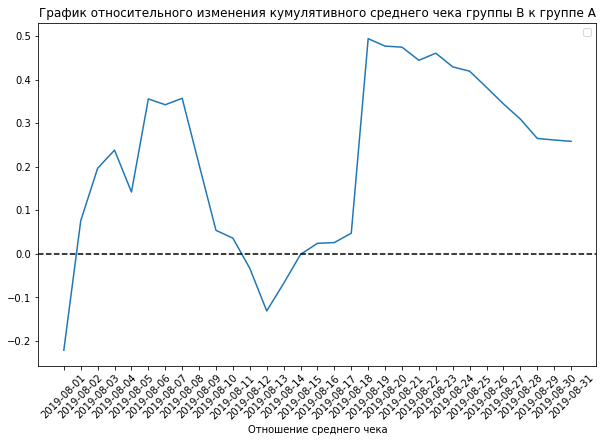

In [34]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

fig = plt.figure(figsize=[10,7])
fig.autofmt_xdate()
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Ось х')
plt.xlabel('Отношение среднего чека')

plt.xticks(rotation = 45)


plt.legend() 
plt.show() 

На графике относительного различия в среднем чеке между группами мы видим, что в несколько дат были совершены очень большие заказы.

### Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.

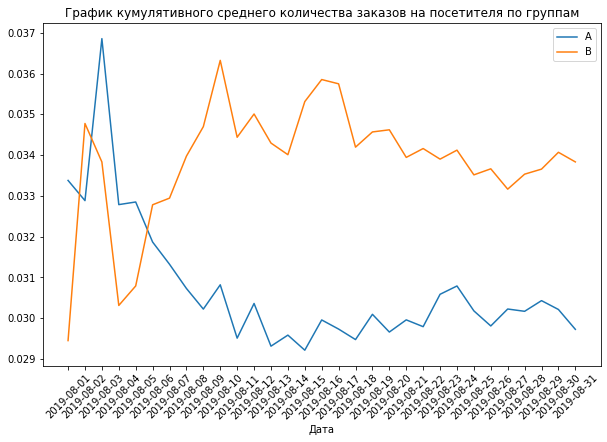

In [35]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
fig = plt.figure(figsize=[10,7])
fig.autofmt_xdate()

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Cреднее количество заказов на посетителя по группам')
plt.xlabel('Дата')

plt.xticks(rotation = 45)


plt.legend() 
plt.show() 


В начале теста группа А имела большую конверсию, но динамично у группы В значительно лучше конверсия.

### Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.

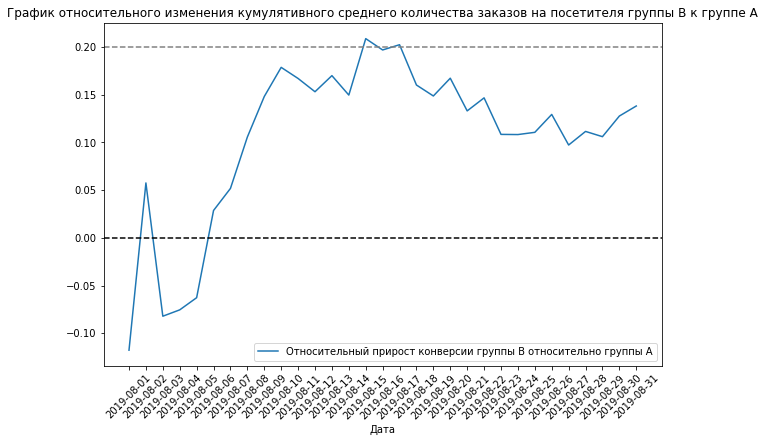

In [36]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

fig = plt.figure(figsize=[10,7])
fig.autofmt_xdate()

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Cреднее количество заказов на посетителя группы B к группе A')
plt.xlabel('Дата')

plt.xticks(rotation = 45)


plt.legend() 
plt.show() 

На графике относительного различия конверсии между группами мы видим, что группа В лидирует по конверсии примерно с середины теста около 20% прироста относительно группы А.

### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

Text(0.5, 1.0, 'Точечный график количества заказов по пользователям')

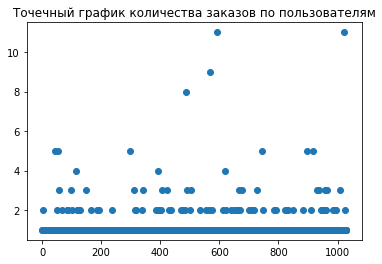

In [37]:
ordersByUsers = (
    orders.groupby('visitorid', as_index=False)
    .agg({'transactionid': 'nunique'}))
ordersByUsers.columns = ['visitorid', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False)

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Точечный график количества заказов по пользователям')

Пользователей, заказавших более 2 раз мало. Они могут быть аномальными.

### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [38]:
ordersByUsers = (
    orders.groupby('visitorid', as_index=False)
    .agg({'transactionid': 'nunique'}))
ordersByUsers.columns = ['visitorid', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head(10)
np.percentile(ordersByUsers['orders'], [90,95, 99])

array([1., 2., 4.])

Не более 5% пользователей совершали более 2-х заказов и не более 1% процента пользователей - более 4-х заказов. Примем за аномальных пользователей тех, кто совершил 4 заказа и более. Так, мы уберем 1% пользователей с наибольшим числом заказов.

### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

Text(0.5, 1.0, 'Точечный график стоимостей заказов')

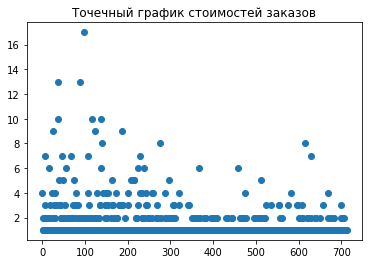

In [39]:
ordersByUsers = (
    orders.groupby('revenue', as_index=False)
    .agg({'transactionid': 'nunique'}))
ordersByUsers.columns = ['revenue', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False)

x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Точечный график стоимостей заказов')

Очень дорогих заказов мало, чем дороже чем меньше. Начиная с 2 тысяч заказов становится значительно меньше.

### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.


In [40]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

Не более чем у 5% заказов стоимость выше чем 28 000 рублей и не более чем у 1% заказов - 58 233 рублей. Примем за аномальных пользователей тех, кто совершил заказ на сумму свыше 29 000 рублей. Так мы уберём от 1% до 5% заказов с наибольшей стоимостью.

### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.


In [41]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
 
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}),
    axis=1,)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
 
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
 
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}),axis=1,)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
 
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'}))
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
 
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}),
    axis=1,).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',]
 
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'}))
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
 
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}),
    axis=1,).sort_values(by=['date'])
ordersBCummulative.columns = ['date',
    'ordersCummulativeB',
    'revenueCummulativeB',]
 
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left')
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left'))

Формулировка гипотез:

H_0: Среднее количество заказов на посетителя группы А = средний чек группы В

H_а: Среднее количество заказов на посетителя группы А «≠» средний чек группы В

In [42]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique}))
ordersByUsersA.columns = ['userid', 'orders']
 
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique}))
ordersByUsersB.columns = ['userid', 'orders']
 
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
            name='orders',),],axis=0,)
 
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0,index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
            name='orders',),],axis=0,)
 
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.017
0.138


P-value значительно меньше 0,05 потому отвергаем нулевую гипотезу. В среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы В к конверсии группы А составляет 13,8%.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.


Формулировка гипотез:

H_0: Средний чек группы А = средний чек группы В
    
H_а: Средний чек группы А «≠» средний чек группы В
    

In [43]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.729
0.259


P-value больше 0,05 - статистически значимых отличий в среднем чеке между группами нет. Кроме того, относительное различие среднего чека между группами 2,6%.

### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.

In [44]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['userid', 'orders']
 
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique}))
ordersByUsersB.columns = ['userid', 'orders']



usersWithManyOrders = pd.concat([
        ordersByUsersA[ordersByUsersA['orders'] > 4]['userid'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['userid'],],axis=0,)

usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorid']


abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values())

In [45]:
sampleAFiltered = pd.concat([ordersByUsersA[
            np.logical_not(ordersByUsersA['userid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
            name='orders',),],axis=0,)

sampleBFiltered = pd.concat([ordersByUsersB[
            np.logical_not(ordersByUsersB['userid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders',),],axis=0,) 

Формулировка гипотез:

H_0: Среднее количество заказов на посетителя группы А = средний чек группы В

H_а: Среднее количество заказов на посетителя группы А «≠» средний чек группы В

In [46]:
print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.01846
0.145


Статистическая значимость достигнута. Группа В лучше группы А.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.


Формулировка гипотез:

H_0: Средний чек группы А = средний чек группы В
    
H_а: Средний чек группы А «≠» средний чек группы В
    

In [47]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),)
            ]['revenue'],orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),)
            ]['revenue'],)[1]))

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),)
        ]['revenue'].mean()/ orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),)
        ]['revenue'].mean()- 1))

0.961
-0.014


P-value увеличился, но и разница между группами  по среднему чеку не сильно изменилась с 2,6% до 1,4%.

### Примите решение по результатам теста и объясните его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.


1) Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
2) Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.
3) На графике относительного различия конверсии между группами мы видим, что группа В лидирует по конверсии примерно с середины теста около 20% прироста относительно группы А.

Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Вероятность, что при имеющихся данных сегмент B на самом деле лучше сегмента A — имеет место быть. (Вариант 1)


<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проекту**

Мичилина, спасибо за твой проект! Ты приложила много усилий, чтобы довести его до конца, все задачи в рамках проекта тебе удалось успешно решить, это видно невооруженным глазом, отличная работа! У меня есть несколько рекомендаций, над которыми стоит поработать.

**Отмечу отдельные положительные моменты проекта🙂**:
* На разных шагах проекта ты предлагала очень интересные решения и методы для их реализации. Хорошая работа!
* Ты активно работала с визуализацией, хорошо, что ты используешь графики в работе над проектами!
* Тест для проверки гипотез выбран верно, интерпретация результатов теста также корректна:)
* Проект в целом хорошо структурирован и оформлен, это плюс:)

    
**На что стоит обратить внимание:🙂**:

* Важно дооформить графики
* Попробуй найти пользователей, попавших в обе группы и провести другие проверки качества данных.
* В случае каждого теста важно добавить формулировки гипотез.
* Можно поработать над комментариями в желтых блоках, носящих рекомендательный характер.
    
**Желаю удачи и жду твой проект на повторное ревью!**😉
    
![gif](https://media.giphy.com/media/l41Yh1olOKd1Tgbw4/giphy.gif)

<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проекту:вторая итерация ревью**

Мичилина, спасибо, что прислала проект с доработками! Все основные моменты исправлены и скорректированы, хорошая работа! 
    
Спешу тебе сообщить, что твой проект принят и ты можешь перейти на следующий спринт🐱‍🏍
    
Желаю тебе крутых и интересных проектов на следующих спринтах🙌😉
    
С прошедшим международным женским днем!

    
![gif](https://media.giphy.com/media/yf5t6Zj45o20ZGN2iA/giphy.gif)